**Nina Dobša, zadnje mijenjano 28.7.2025.**

> Dodaj oznaku dugog citata



# Imports

In [1]:
%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForMaskedLM
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Connecting with google drive where fine tuned models are stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Uploading ISEAR data
file_path = "/content/drive/My Drive/data/isear_3.txt"
ISEAR_data = pd.read_csv(file_path, delimiter="|", header=0, on_bad_lines="skip", engine="python")

# Select only Emotion and Text columns from original dataset
ISEAR_data = ISEAR_data[['SIT', 'Field1']]
ISEAR_data.columns = ['text', 'emotion']
ISEAR_data.shape

(7505, 2)

In [6]:
# Encoding emotions (from words to numbers)
label_encoder = LabelEncoder()
ISEAR_data['emotion_label'] = label_encoder.fit_transform(ISEAR_data['emotion'])
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}


In [7]:
# Defining number of classes and length of the sequence (if the sentence is shorter padding will be added)
num_classes = 7
max_sequence_length = 30

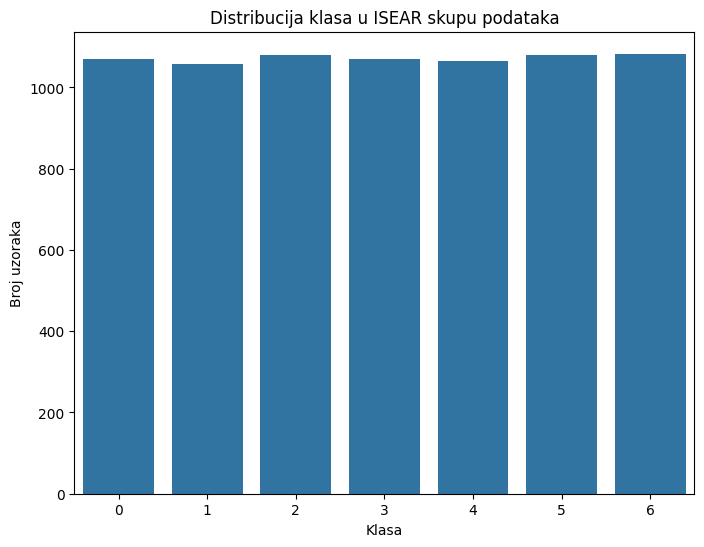

In [8]:
# Visualization of class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='emotion_label', data=ISEAR_data)
plt.title('Distribucija klasa u ISEAR skupu podataka')
plt.xlabel('Klasa')
plt.ylabel('Broj uzoraka')
plt.show()

Classes are balanced...

# Word2Vec Embeddings

In [9]:
# Import of fine tuned word2vec model
model_path_SG = "/content/drive/My Drive/fine_tuned_word2vec_sg/fine_tuned_word2vec_sg.model"
model_path_CBOW = "/content/drive/My Drive/fine_tuned_word2vec_cbow/fine_tuned_word2vec_cbow.model"
word2vec_model_SG = Word2Vec.load(model_path_SG)
word2vec_model_CBOW = Word2Vec.load(model_path_CBOW)

embedding_dim_SG = word2vec_model_SG.vector_size
embedding_dim_CBOW = word2vec_model_CBOW.vector_size

In [10]:
# Function for getting word2vec embeddings
def get_word2vec_embeddings(sentence, model):
    # Tokenization
    sentence = sentence.lower()
    words = sentence.split()
    word_embeddings = [model.wv[word] for word in words if word in model.wv]

    if not word_embeddings:  # If no words are in the vocabulary, return a zero vector
        return []

    return word_embeddings

In [11]:
# Getting word2vec embeddings for each word in the sentence (except stowords)
list_of_embeddings_CBOW = [
   get_word2vec_embeddings(text, word2vec_model_CBOW)
    for text in ISEAR_data['text']
]

list_of_embeddings_SG = [
   get_word2vec_embeddings(text, word2vec_model_SG)
    for text in ISEAR_data['text']
]

In [12]:
# Padding sequences to the same length -> adding zeroes to the sequences shorter than embedding_dim and cutting sequences longer than embedding_dim
# Converting to NumPy array
embeddings_CBOW = pad_sequences(
    list_of_embeddings_CBOW,
    maxlen = max_sequence_length,
    dtype = 'float32',
    padding = 'post',
    truncating = 'post'
)

# print(embeddings_CBOW)

In [13]:
# Padding sequences to the same length -> adding zeroes to the sequences shorter than embedding_dim and cutting sequences longer than embedding_dim
# Converting to NumPy array
embeddings_SG = pad_sequences(
    list_of_embeddings_SG,
    maxlen = max_sequence_length,
    dtype = 'float32',
    padding = 'post',
    truncating = 'post'
)

# print(embeddings_SG)

In [14]:
# One-hot encoding of target values
y = to_categorical(ISEAR_data['emotion_label'], num_classes=num_classes)
y_original_labels = ISEAR_data['emotion_label'].values

print(f"Dimensions of embeddings_CBOW: {embeddings_CBOW.shape}") # (number_of_examples, sequence_length, embedding_dim)
print(f"Dimensions of embeddings_SG: {embeddings_SG.shape}") # (number_of_examples, sequence_length, embedding_dim)
print(f"Dimensions of target value: {y.shape}") # (number_of_examples, num_classes)

Dimensions of embeddings_CBOW: (7505, 30, 300)
Dimensions of embeddings_SG: (7505, 30, 300)
Dimensions of target value: (7505, 7)


# RNN predictions for Word2Vec embeddings

### Predictions for SG embeddings

In [15]:
# Model parameters
n_splits = 5 # 5-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
lstm_units = 128
dropout_rate = 0.3

fold_accuracies = []
fold_losses = []
fold_f1_macros = []
fold_auc_macros = []
fold_precision_macros = []
fold_recall_macros = []

for fold, (train_index, val_index) in enumerate(skf.split(embeddings_SG, y_original_labels)):
    print(f"\n--- Training Fold {fold + 1}/{n_splits} ---")

    X_train_fold, X_val_fold = embeddings_SG[train_index], embeddings_SG[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    clear_session() # Reseting Keras session to build new model

    # Building an LSTM Bidirectional model
    model = Sequential()
    model.add(Input(shape=(max_sequence_length, embedding_dim_SG)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping Callback - to prevent model of overfitting
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy', # We are tracking validation accuracy
        patience=5,             # The training stops if the val_accuracy doesn't get better after 5 epochs
        restore_best_weights=True,
        mode='max',             # Maximizing accuracy
        verbose=1
    )

    # Training the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,   # trining in 50 epochs (we assume early stopping call back will end the training before)
        batch_size=batch_size,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_callback],
        verbose=0
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    y_pred_probs_fold = model.predict(X_val_fold, verbose=0)
    y_pred_classes_fold = np.argmax(y_pred_probs_fold, axis=1)
    y_true_classes_fold = np.argmax(y_val_fold, axis=1)

    precision_macro_fold = precision_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    recall_macro_fold = recall_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)

    fold_precision_macros.append(precision_macro_fold)
    fold_recall_macros.append(recall_macro_fold)

    f1_macro_fold = f1_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    fold_f1_macros.append(f1_macro_fold)

    try:
        auc_macro_fold = roc_auc_score(y_true_classes_fold, y_pred_probs_fold, multi_class='ovr', average='macro')
        fold_auc_macros.append(auc_macro_fold)
    except ValueError as e:
        fold_auc_macros.append(np.nan)

    # Printing results for the current fold
    print(f"   Fold {fold + 1} - Val Loss: {loss:.4f}, Val Acc: {accuracy:.4f}, Val Precision-macro: {precision_macro_fold:.4f}, Val Recall-macro: {recall_macro_fold:.4f}, Val F1-macro: {f1_macro_fold:.4f}, Val AUC-macro: {fold_auc_macros[-1]:.4f}")


--- Training Fold 1/5 ---
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
   Fold 1 - Val Loss: 1.3507, Val Acc: 0.5383, Val Precision-macro: 0.5411, Val Recall-macro: 0.5383, Val F1-macro: 0.5377, Val AUC-macro: 0.8474

--- Training Fold 2/5 ---
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
   Fold 2 - Val Loss: 1.3344, Val Acc: 0.5390, Val Precision-macro: 0.5538, Val Recall-macro: 0.5393, Val F1-macro: 0.5391, Val AUC-macro: 0.8466

--- Training Fold 3/5 ---
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
   Fold 3 - Val Loss: 1.3778, Val Acc: 0.5250, Val Precision-macro: 0.5513, Val Recall-macro: 0.5251, Val F1-macro: 0.5283, Val AUC-macro: 0.8457

--- Training Fold 4/5 ---
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
   Fold 4 - Val Loss: 1.2779, Val Acc: 0.5536, Val Precision-macro: 0.5604, Val Recall-macro: 0.5536, Val F1-macro: 

In [16]:
# Calculation of average results across all folds +/ std.dev
print("\n--- Average cross validation results for Word2Vec SG embeddings ---")
print(f"Val Loss: {np.mean(fold_losses):.4f} +/- {np.std(fold_losses):.4f}")
print(f"Val Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Val Precision-macro: {np.mean(fold_precision_macros):.4f} +/- {np.std(fold_precision_macros):.4f}")
print(f"Val Recall-macro: {np.mean(fold_recall_macros):.4f} +/- {np.std(fold_recall_macros):.4f}")
print(f"Val F1-macro: {np.mean(fold_f1_macros):.4f} +/- {np.std(fold_f1_macros):.4f}")
print(f"Val AUC-macro: {np.nanmean(fold_auc_macros):.4f} +/- {np.nanstd(fold_auc_macros):.4f}")


--- Average cross validation results for Word2Vec SG embeddings ---
Val Loss: 1.3269 +/- 0.0366
Val Accuracy: 0.5388 +/- 0.0091
Val Precision-macro: 0.5516 +/- 0.0062
Val Recall-macro: 0.5390 +/- 0.0090
Val F1-macro: 0.5392 +/- 0.0078
Val AUC-macro: 0.8506 +/- 0.0051


### Predictions for CBOW embeddings

In [17]:
# Model parameters
n_splits = 5 # 5-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
lstm_units = 128
dropout_rate = 0.3

fold_accuracies = []
fold_losses = []
fold_f1_macros = []
fold_auc_macros = []
fold_precision_macros = []
fold_recall_macros = []

for fold, (train_index, val_index) in enumerate(skf.split(embeddings_CBOW, y_original_labels)):
    print(f"\n--- Training Fold {fold + 1}/{n_splits} ---")

    X_train_fold, X_val_fold = embeddings_CBOW[train_index], embeddings_CBOW[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    clear_session() # Reseting Keras session to build new model

    # Building an LSTM Bidirectional model
    model = Sequential()
    model.add(Input(shape=(max_sequence_length, embedding_dim_CBOW)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping Callback - to prevent model of overfitting
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy', # We are tracking validation accuracy
        patience=5,             # The training stops if the val_accuracy doesn't get better after 5 epochs
        restore_best_weights=True,
        mode='max',             # Maximizing accuracy
        verbose=1
    )

    # Training the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,   # trining in 50 epochs (we assume early stopping call back will end the training before)
        batch_size=batch_size,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_callback],
        verbose=0
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    y_pred_probs_fold = model.predict(X_val_fold, verbose=0)
    y_pred_classes_fold = np.argmax(y_pred_probs_fold, axis=1)
    y_true_classes_fold = np.argmax(y_val_fold, axis=1)

    precision_macro_fold = precision_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    recall_macro_fold = recall_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)

    fold_precision_macros.append(precision_macro_fold)
    fold_recall_macros.append(recall_macro_fold)

    f1_macro_fold = f1_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    fold_f1_macros.append(f1_macro_fold)

    try:
        auc_macro_fold = roc_auc_score(y_true_classes_fold, y_pred_probs_fold, multi_class='ovr', average='macro')
        fold_auc_macros.append(auc_macro_fold)
    except ValueError as e:
        fold_auc_macros.append(np.nan)

    # Printing results for the current fold
    print(f"   Fold {fold + 1} - Val Loss: {loss:.4f}, Val Acc: {accuracy:.4f}, Val Precision-macro: {precision_macro_fold:.4f}, Val Recall-macro: {recall_macro_fold:.4f}, Val F1-macro: {f1_macro_fold:.4f}, Val AUC-macro: {fold_auc_macros[-1]:.4f}")


--- Training Fold 1/5 ---
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
   Fold 1 - Val Loss: 1.4269, Val Acc: 0.5010, Val Precision-macro: 0.5106, Val Recall-macro: 0.5010, Val F1-macro: 0.4982, Val AUC-macro: 0.8251

--- Training Fold 2/5 ---
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
   Fold 2 - Val Loss: 1.5808, Val Acc: 0.5310, Val Precision-macro: 0.5381, Val Recall-macro: 0.5311, Val F1-macro: 0.5291, Val AUC-macro: 0.8309

--- Training Fold 3/5 ---
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
   Fold 3 - Val Loss: 1.5612, Val Acc: 0.5037, Val Precision-macro: 0.5018, Val Recall-macro: 0.5040, Val F1-macro: 0.5008, Val AUC-macro: 0.8203

--- Training Fold 4/5 ---
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
   Fold 4 - Val Loss: 1.3899, Val Acc: 0.5203, Val Precision-macro: 0.5241, Val Recall-macro: 0.5204, Val F1-macro: 0.

In [18]:
# Calculation of average results across all folds +/ std.dev
print("\n--- Average cross validation results for Word2Vec CBOW embeddings ---")
print(f"Val Loss: {np.mean(fold_losses):.4f} +/- {np.std(fold_losses):.4f}")
print(f"Val Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Val Precision-macro: {np.mean(fold_precision_macros):.4f} +/- {np.std(fold_precision_macros):.4f}")
print(f"Val Recall-macro: {np.mean(fold_recall_macros):.4f} +/- {np.std(fold_recall_macros):.4f}")
print(f"Val F1-macro: {np.mean(fold_f1_macros):.4f} +/- {np.std(fold_f1_macros):.4f}")
print(f"Val AUC-macro: {np.nanmean(fold_auc_macros):.4f} +/- {np.nanstd(fold_auc_macros):.4f}")


--- Average cross validation results for Word2Vec CBOW embeddings ---
Val Loss: 1.4709 +/- 0.0829
Val Accuracy: 0.5135 +/- 0.0110
Val Precision-macro: 0.5185 +/- 0.0123
Val Recall-macro: 0.5137 +/- 0.0110
Val F1-macro: 0.5121 +/- 0.0116
Val AUC-macro: 0.8282 +/- 0.0062


# BERT Embeddings

In [19]:
# Import of fine tuned bert model
model_path = "/content/drive/My Drive/fine_tuned_bert"
bert_tokenizer = BertTokenizer.from_pretrained(model_path)
bert_model = BertForMaskedLM.from_pretrained(model_path)
embedding_dim_bert = bert_model.config.hidden_size

In [20]:
# Function for getting bert embeddings
def get_bert_embeddings(sentence, bert_model, bert_tokenizer, max_sequence_length_for_lstm):

    padding_zeroes = np.zeros(embedding_dim_bert, dtype=np.float32) # used to pad sequences shorter than sequence_length (50)

    inputs = bert_tokenizer(
        sentence,
        return_tensors='pt',
        truncation=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert_model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(
            input_ids=inputs['input_ids'],
            attention_mask=inputs.get('attention_mask', None),
            token_type_ids=inputs.get('token_type_ids', None),
            output_hidden_states=True
        )

    # Get the last hidden state (token embeddings)
    token_embeddings_np = outputs.hidden_states[-1].squeeze(0).cpu().numpy()
    input_ids = inputs['input_ids'].squeeze(0).cpu().numpy()

    # Filter out special tokens and empty strings
    filtered_embeddings_list = []
    for i, token_id in enumerate(input_ids):
        token_str = bert_tokenizer.decode(token_id)

        if token_str in bert_tokenizer.all_special_tokens or not token_str.strip():
            continue

        filtered_embeddings_list.append(token_embeddings_np[i])

    current_len = len(filtered_embeddings_list)

    if current_len == 0:
        return np.full((max_sequence_length_for_lstm, embedding_dim_bert), padding_zeroes, dtype=np.float32)

    # Initialize the final embeddings array with padding zeroes
    final_embeddings_array = np.full((max_sequence_length_for_lstm, embedding_dim_bert), padding_zeroes, dtype=np.float32)

    # If the current length is greater than or equal to the max sequence length (50), truncate the list
    # else, fill the array with the available embeddings
    if current_len >= max_sequence_length_for_lstm:
        final_embeddings_array = np.array(filtered_embeddings_list[:max_sequence_length_for_lstm], dtype=np.float32)
    else:
        final_embeddings_array[:current_len] = np.array(filtered_embeddings_list, dtype=np.float32)

    return final_embeddings_array

In [21]:
# Getting bert embeddings for each word in the sentence
list_of_embeddings_BERT = [
   get_bert_embeddings(text, bert_model, bert_tokenizer, max_sequence_length)
    for text in ISEAR_data['text']
]

In [22]:
# Padding sequences to the same length -> adding zeroes to the sequences shorter than embedding_dim and cutting sequences longer than embedding_dim
# Converting to NumPy array
embeddings_BERT = pad_sequences(
    list_of_embeddings_BERT,
    maxlen = max_sequence_length,
    dtype = 'float32',
    padding = 'post',
    truncating = 'post'
)

# print (embeddings_BERT)

In [23]:
# One-hot encoding of target values
y = to_categorical(ISEAR_data['emotion_label'], num_classes=num_classes)

print(f"\nDimensions of embeddings_BERT: {embeddings_BERT.shape}") # (number_of_examples, sequence_length, embedding_dim)
print(f"Dimensions of target value: {y.shape}") # (number_of_examples, num_classes)


Dimensions of embeddings_BERT: (7505, 30, 768)
Dimensions of target value: (7505, 7)


# RNN predictions for BERT Embeddings

In [24]:
# Model parameters
n_splits = 5 # 5-fold cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
epochs = 50
batch_size = 32
lstm_units = 128
dropout_rate = 0.3

fold_accuracies = []
fold_losses = []
fold_f1_macros = []
fold_auc_macros = []
fold_precision_macros = []
fold_recall_macros = []

for fold, (train_index, val_index) in enumerate(skf.split(embeddings_BERT, y_original_labels)):
    print(f"\n--- Training Fold {fold + 1}/{n_splits} ---")

    X_train_fold, X_val_fold = embeddings_BERT[train_index], embeddings_BERT[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    clear_session() # Reseting Keras session to build new model

    # Building an LSTM Bidirectional model
    model = Sequential()
    model.add(Input(shape=(max_sequence_length, embedding_dim_bert)))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping Callback - to prevent model of overfitting
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy', # We are tracking validation accuracy
        patience=5,             # The training stops if the val_accuracy doesn't get better after 5 epochs
        restore_best_weights=True,
        mode='max',             # Maximizing accuracy
        verbose=1
    )

    # Training the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,   # trining in 50 epochs (we assume early stopping call back will end the training before)
        batch_size=batch_size,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping_callback],
        verbose=0
    )

    # Evaluating the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(accuracy)

    y_pred_probs_fold = model.predict(X_val_fold, verbose=0)
    y_pred_classes_fold = np.argmax(y_pred_probs_fold, axis=1)
    y_true_classes_fold = np.argmax(y_val_fold, axis=1)

    precision_macro_fold = precision_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    recall_macro_fold = recall_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)

    fold_precision_macros.append(precision_macro_fold)
    fold_recall_macros.append(recall_macro_fold)

    f1_macro_fold = f1_score(y_true_classes_fold, y_pred_classes_fold, average='macro', zero_division=0)
    fold_f1_macros.append(f1_macro_fold)

    try:
        auc_macro_fold = roc_auc_score(y_true_classes_fold, y_pred_probs_fold, multi_class='ovr', average='macro')
        fold_auc_macros.append(auc_macro_fold)
    except ValueError as e:
        fold_auc_macros.append(np.nan)

    # Printing results for the current fold
    print(f"   Fold {fold + 1} - Val Loss: {loss:.4f}, Val Acc: {accuracy:.4f}, Val Precision-macro: {precision_macro_fold:.4f}, Val Recall-macro: {recall_macro_fold:.4f}, Val F1-macro: {f1_macro_fold:.4f}, Val AUC-macro: {fold_auc_macros[-1]:.4f}")


--- Training Fold 1/5 ---
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
   Fold 1 - Val Loss: 1.2539, Val Acc: 0.6203, Val Precision-macro: 0.6190, Val Recall-macro: 0.6204, Val F1-macro: 0.6170, Val AUC-macro: 0.8934

--- Training Fold 2/5 ---
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
   Fold 2 - Val Loss: 1.1440, Val Acc: 0.6129, Val Precision-macro: 0.6184, Val Recall-macro: 0.6127, Val F1-macro: 0.6098, Val AUC-macro: 0.8922

--- Training Fold 3/5 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
   Fold 3 - Val Loss: 1.0828, Val Acc: 0.6482, Val Precision-macro: 0.6478, Val Recall-macro: 0.6486, Val F1-macro: 0.6453, Val AUC-macro: 0.9054

--- Training Fold 4/5 ---
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
   Fold 4 - Val Loss: 1.1946, Val Acc: 0.6243, Val Precision-macro: 0.6234, Val Recall-macro: 0.6246, Val F1-macro: 0.

In [25]:
# Calculation of average results across all folds +/ std.dev
print("\n--- Average cross validation results for Word2Vec BERT embeddings ---")
print(f"Val Loss: {np.mean(fold_losses):.4f} +/- {np.std(fold_losses):.4f}")
print(f"Val Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Val Precision-macro: {np.mean(fold_precision_macros):.4f} +/- {np.std(fold_precision_macros):.4f}")
print(f"Val Recall-macro: {np.mean(fold_recall_macros):.4f} +/- {np.std(fold_recall_macros):.4f}")
print(f"Val F1-macro: {np.mean(fold_f1_macros):.4f} +/- {np.std(fold_f1_macros):.4f}")
print(f"Val AUC-macro: {np.nanmean(fold_auc_macros):.4f} +/- {np.nanstd(fold_auc_macros):.4f}")


--- Average cross validation results for Word2Vec BERT embeddings ---
Val Loss: 1.1591 +/- 0.0597
Val Accuracy: 0.6249 +/- 0.0122
Val Precision-macro: 0.6273 +/- 0.0108
Val Recall-macro: 0.6251 +/- 0.0124
Val F1-macro: 0.6227 +/- 0.0120
Val AUC-macro: 0.8972 +/- 0.0048
